# This notebook does IA modeling.

Notebook by: Jonathan Blazek (blazek@berkeley.edu)  
FAST-PT on github: https://github.com/JoeMcEwen/FAST-PT  
Easy ccl installation in a conda environment: `conda install -c conda-forge pyccl`  
Easy fast-pt installation: `pip install fast-pt`  
(Note, use `--no-deps` if you use `conda` for most python packages)

In [1]:
# import standard packages
import numpy as np
import pylab as plt
%matplotlib inline
from scipy.interpolate import interp1d

# import fastpt
import fastpt as fpt
import fastpt.HT as HT

# import the Core Cosmology Library (CCL) if you have it
try:
    import pyccl as ccl
    import pyccl.ccllib as lib
    import pyccl.nl_pt as pt
    have_ccl = True
except:
    have_ccl = False
    print('CCL not found. Steps with CCL will be skipped.')

# If you want to test HT against external Bessel transform code, e.g. mcfit
try:
    from mcfit import P2xi
    have_mcfit = True
except:
    have_mcfit = False
    print('mcfit not found. Steps with mcfit will be skipped.')

mcfit not found. Steps with mcfit will be skipped.


<h3> Get $P_{\rm lin}(k)$ and $P_{\rm nl}(k)$: </h3>

In [2]:
## Get from CCL (which runs CLASS by default)

#cosmological_parameters--omega_m         ~ delta(0.315)
#cosmological_parameters--h0              ~ delta(0.67)
#cosmological_parameters--omega_b         ~ delta(0.045)
#cosmological_parameters--n_s             ~ delta(0.96)
#cosmological_parameters--a_s             ~ delta(2.1e-09)
#cosmological_parameters--omnuh2          ~ delta(0.0)

if have_ccl:
    # set a cosmology
    #original
   # Omega_c=0.27
   # Omega_b=0.045
   # cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)
   # h=0.67
   # Omega_m=Omega_c+Omega_b
   # Omega_m_0=Omega_m
    
    #Planck (for Sara's paper) (1807.06209)
    Omega_m = 0.3158
    Omega_b = 0.0494
    Omega_c= Omega_m - Omega_b
    h=0.6732
    n_s=0.96605
    sigma8=0.812
    cosmo = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, sigma8=sigma8, n_s=n_s)
    Omega_m_0=Omega_m

    # Get the linear power spectrum at z=0 for our given cosmologies
    # k array to be used for power spectra
    nk = 512
    log10kmin = -5
    log10kmax = 2
    ks = np.logspace(log10kmin,log10kmax,nk)
    k = ks/h # convert to h/Mpc
    
    # at individual power spectra
    pk_lin_z0 = h**3*ccl.linear_matter_power(cosmo,ks,1)
    pk_lin_z1 = h**3*ccl.linear_matter_power(cosmo,ks,0.5)
    pk_nl_z0 = h**3*ccl.nonlin_matter_power(cosmo,ks,1)
    pk_nl_z1 = h**3*ccl.nonlin_matter_power(cosmo,ks,0.5)
    
    
    # interpolation Pk
    z = np.linspace(0, 1.5, 1024)
    gz = ccl.growth_factor(cosmo, 1./(1+z))
    sf = (1./(1+z))[::-1]
    # Note this has been converted to Mpc/h units
    lpk_array = np.log(np.array([h**3*ccl.linear_matter_power(cosmo,ks,a) for a in sf]))
    pk_lin = ccl.Pk2D(a_arr=sf, lk_arr=np.log(k), pk_arr=lpk_array, is_logp=True)
    lpk_array = np.log(np.array([h**3*ccl.nonlin_matter_power(cosmo,ks,a) for a in sf]))
    pk_nl = ccl.Pk2D(a_arr=sf, lk_arr=np.log(k), pk_arr=lpk_array, is_logp=True)

## Or get from pre-computed CAMB run
# This file is in the same examples/ folder
d = np.loadtxt('Pk_test.dat')
k_CAMB = d[:, 0]
pk_CAMB = d[:, 1]
p22 = d[:, 2]
p13 = d[:, 3]

if not have_ccl:
    ks = k
    pk_lin_z0 = pk
    
## Or get from your preferred Boltzmann code

# Note: k needs to be evenly log spaced. FAST-PT will raise an error if it's not.

# Note: CCL outputs in units of Mpc not Mpc/h

In [3]:
# Galaxy biases
#b_1 = 2.0 # constant values for now. But can also be z-dependent
b_2 = 1.0
b_s = 1.0

bias_redmagic = 1.6
b_1 = bias_redmagic


# Biases for IAs. Will be converted to the input c_IA values below.
a_1 = 1.
a_2 = 0.5
a_d = 0.5

# Let's convert the a_IA values into the correctly normalized c_IA values:
# First, do it explicitly:
Om_m = cosmo['Omega_m']
rho_crit = lib.cvar.constants.RHO_CRITICAL
rho_m = lib.cvar.constants.RHO_CRITICAL * cosmo['Omega_m']
Om_m_fid = 0.3 #or could use DES convention and just remove Om_m/Om_m_fid

c_1_t = -1*a_1*5e-14*rho_crit*cosmo['Omega_m']/gz
c_d_t = -1*a_d*5e-14*rho_crit*cosmo['Omega_m']/gz
c_2_t_B = a_2*5*5e-14*rho_crit*cosmo['Omega_m']**2/(Om_m_fid*gz**2) #Blazek2019 convention
c_2_t = a_2*5*5e-14*rho_crit*cosmo['Omega_m']/(gz**2) #DES convention

# Or we just use the built-in function for IA normalization:
c_1,c_d,c_2 = pt.translate_IA_norm(cosmo, z, a1=a_1, a1delta=a_d, a2=a_2, Om_m2_for_c2 = False)

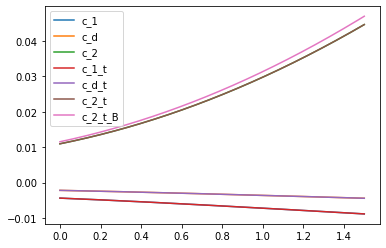

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [4]:
# testing the pt.translate_IA_norm function

plt.plot(z,c_1,label='c_1')
plt.plot(z,c_d,label='c_d')
plt.plot(z,c_2,label='c_2')
plt.plot(z,c_1_t,label='c_1_t')
plt.plot(z,c_d_t,label='c_d_t')
plt.plot(z,c_2_t,label='c_2_t')
plt.plot(z,c_2_t_B,label='c_2_t_B')
plt.legend()
plt.show()

c_1[1:1000]/c_1_t[1:1000]

In [5]:
# Set FAST-PT settings.

# the to_do list sets the k-grid quantities needed in initialization (e.g. the relevant gamma functions)
to_do = ['one_loop_dd', 'dd_bias', 'IA_all']

pad_factor = 1 # padding the edges with zeros before Pk repeats
n_pad = pad_factor*len(ks)
low_extrap = -5 # Extend Plin to this log10 value if necessary (power law)
high_extrap = 3 # Extend Plin to this log10 value if necessary (power law)
P_window = None # Smooth the input power spectrum edges (typically not needed, especially with zero padding)
C_window = .75 # Smooth the Fourier coefficients of Plin to remove high-frequency noise.

<h3> Initialize a FAST-PT object on a given k-grid. </h3>
<h3> This step does not depend on cosmology and can be re-used, e.g. in an MCMC. </h3>

In [6]:
# FAST-PT will parse the full to-do list and only calculate each needed quantity once.
# Ideally, the initialization happens once per likelihood evaluation, or even once per chain.

fpt_obj = fpt.FASTPT(ks,to_do=to_do,low_extrap=low_extrap,high_extrap=high_extrap,n_pad=n_pad)

<h3> Or we can use built-in CCL functionality for FAST-PT. This uses PTTracer objects and PTCalculator.</h3>

In [7]:
ptc = pt.PTCalculator(with_NC=True, with_IA=True,
                      log10k_min=-4, log10k_max=2, nk_per_decade=20)

# Number counts (galaxy clustering)
ptt_g = pt.PTNumberCountsTracer(b1=b_1, b2=b_2, bs=b_s)

# Intrinsic alignments
ptt_i = pt.PTIntrinsicAlignmentTracer(c1=(z,c_1), c2=(z,c_2), cdelta=(z,c_d)) # full TATT model
ptt_i_nla = pt.PTIntrinsicAlignmentTracer(c1=(z,c_1)) # NLA model

# Matter
ptt_m = pt.PTMatterTracer()

# Note that we've assumed constant biases for simplicity, but you can also make them z-dependent:
bz = b_1 / gz
ptt_g_b = pt.PTNumberCountsTracer(b1=(z, bz))

In [8]:
# Calculate some power spectra with FAST-PT

# Galaxies x galaxies.
# If `tracer2` is missing, an auto-correlation for the first tracer is assumed.
pk_gg = pt.get_pt_pk2d(cosmo, ptt_g, ptc=ptc)

# Galaxies x matter
pk_gm = pt.get_pt_pk2d(cosmo, ptt_g, tracer2=ptt_m, ptc=ptc)

# Galaxies x IAs
pk_gi_tatt = pt.get_pt_pk2d(cosmo, ptt_g, tracer2=ptt_i, ptc=ptc)
pk_gi_nla = pt.get_pt_pk2d(cosmo, ptt_g, tracer2=ptt_i_nla, ptc=ptc)

# IAs x IAs
pk_ii, pk_ii_bb = pt.get_pt_pk2d(cosmo, ptt_i, tracer2=ptt_i, ptc=ptc, return_ia_ee_and_bb=True)
pk_ii_nla = pt.get_pt_pk2d(cosmo, ptt_i_nla, tracer2=ptt_i_nla, ptc=ptc)

# IAs x matter
pk_im = pt.get_pt_pk2d(cosmo, ptt_i, tracer2=ptt_m, ptc=ptc)

# Matter x matter
pk_mm = pt.get_pt_pk2d(cosmo, ptt_m, tracer2=ptt_m, ptc=ptc)

<h3> Evaluate the NLA model. </h3>

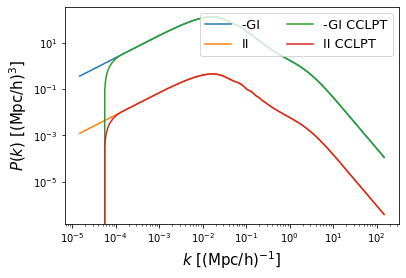

In [9]:
# set the redshift for calculations.
#zz=0.375 # this is currently the mean redshift of our particular redmagic sample.
#zz=0.5 # for redmapper
zz=0.38291525962011247 # mean lens redshift
#zz=0.3875875561595796 # median lens redshift

# These are the NLA model power spectra calculated by hand:
c_1_zz,c_d_zz,c_2_zz = pt.translate_IA_norm(cosmo, zz, a1=a_1, a1delta=a_d, a2=a_2, Om_m2_for_c2 = False)
pk_nl0=pk_nl.eval(k,1./(1+zz),cosmo)
pk_lin0=pk_lin.eval(k,1./(1+zz),cosmo)
p_GI_zz = c_1_zz*pk_nl0
p_II_zz = c_1_zz**2*pk_nl0
p_gI_zz = b_1*p_GI_zz
p_gI_zz_lin = b_1*c_1_zz*pk_lin0

# This is the NLA model, from CCL:
# need to be careful with factors of h in both k and Pk.
# All internal CCL calculations use Mpc instead of Mpc/h
# So we evaluate at ks and multiply by h**3:
p_gI_ccl = h**3*pk_gi_nla.eval(ks,1./(1+zz),cosmo)
p_II_ccl = h**3*pk_ii_nla.eval(ks,1./(1+zz),cosmo)

#This is the full TATT model, from CCL
p_gI_tatt = h**3*pk_gi_tatt.eval(ks,1./(1+zz),cosmo)

plt.loglog()
plt.plot(k,-1*p_gI_zz,label='-GI')
plt.plot(k,p_II_zz,label='II')
plt.plot(k,-1*p_gI_ccl,label='-GI CCLPT')
plt.plot(k,p_II_ccl,label='II CCLPT')
plt.legend(loc='upper right', ncol=2, fontsize=13)
plt.xlabel(r'$k\,\,[{\rm (Mpc/h)}^{-1}]$', fontsize=15)
plt.ylabel(r'$P(k)\,\,[{\rm (Mpc/h)^{3}}]$', fontsize=15)
plt.show()

They agree, although there are different extrapolations outside the primary k range.

<h3> FAST-PT includes an implementation of FFTLog for Bessel transforms. </h3>

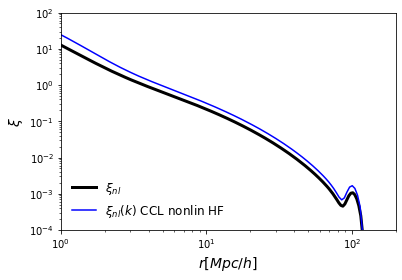

In [10]:
# Calculate the standard correlation function
r,xi = HT.k_to_r(k,pk_nl0,1.5,-1.5,.5, (2.*np.pi)**(-1.5))

if have_mcfit:
    # can test the transform with other code, e.g. mcfit
    rr,xxi = P2xi(k)(pk_nl0)
if have_ccl:
    # can also compare to the output from CCL
    kmin, kmax, nk = 1e-4, 1e1, 128
    rmin, rmax, nr = 1, 2e2, 128
    kccl = np.logspace(np.log10(kmin), np.log10(kmax), nk) # Wavenumber
    rccl = np.logspace(np.log10(rmin), np.log10(rmax), nr)
    a = 1. # Scale factor a z=0
    xi_nl = ccl.correlation_3d(cosmo,a, rccl)

# Make a plot
plt.plot(r,xi, 'k', linewidth=3,label=r'$\xi_{nl}$')
if have_ccl:
    plt.plot(h*rccl,xi_nl, 'b', label=r'$\xi_{nl}(k)$ CCL nonlin HF')
    #remember the factor of h for CCL
if have_mcfit:
    plt.plot(rr ,xxi, 'y--', label=r'$\xi_{nl}(k)$ mcfit')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r [Mpc/h]$', fontsize=14)
plt.ylabel(r'$\xi$', fontsize=14)
plt.xlim(1e0,2e2)
plt.ylim(1e-4,1e2)
plt.legend(loc='lower left', fontsize=12, frameon=False)

<h3> $w_{g+}$ is a $J_2$ transform</h3>

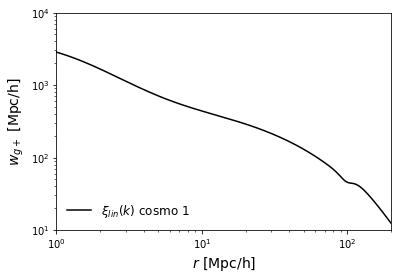

In [11]:
# In the Limber approximation, w_g+ is a simple calculation:

# For the J2 transform (e.g. DeltaSigma or w_g+)
r,xi_2=HT.k_to_r(k,pk_nl0,1.,-1.,2., 4.*np.pi*np.sqrt(np.pi/2.))

# Make a plot
plt.plot(r,xi_2, 'k', label=r'$\xi_{lin}(k)$ cosmo 1')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$ [Mpc/h]', fontsize=14)
plt.ylabel(r'$w_{g+}$ [Mpc/h]', fontsize=14)
plt.xlim(1e0,2e2)
plt.ylim(1e1,1e4)
plt.legend(loc='lower left', fontsize=12, frameon=False)

In [15]:
help(HT.k_to_r)

Help on function k_to_r in module fastpt.HT:

k_to_r(k, f_k, alpha_k=1.5, beta_r=-1.5, mu=0.5, pf=0.06349363593424097, q=0)
    ##########################################################################################
    # function specific for power spectrum to correlation function (and vice versus) in 
    # cosmology



# Now we calculate the properly normalized version

In [17]:
# note the correct pre-factor for w_g+ (see e.g. Blazek2015)
r,wgplus_tatt=HT.k_to_r(k,p_gI_tatt,1.,-1.,2., -1./(2*np.pi))
r,wgplus_nla=HT.k_to_r(k,p_gI_zz,1.,-1.,2., -1./(2*np.pi))
#r,wgplus_nla=HT.k_to_r(k,p_gI_zz,1.,-1.,2., 4.*np.pi*np.sqrt(np.pi/2.))
r,wgplus_nla_ccl=HT.k_to_r(k,p_gI_ccl,1.,-1.,2., -1./(2*np.pi))
r,wgplus_lin=HT.k_to_r(k,p_gI_zz_lin,1.,-1.,2., -1./(2*np.pi))

In [18]:
#
out=np.ones((len(r),2))
out[:,0]=r
out[:,1]=wgplus_nla/b_1
np.savetxt('test05',out)

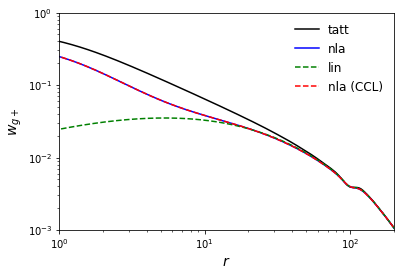

In [19]:
# Make a plot
plt.plot(r,abs(wgplus_tatt), 'k', label=r'tatt')
plt.plot(r,abs(wgplus_nla), 'b', label=r'nla')
plt.plot(r,abs(wgplus_lin), 'g--', label=r'lin')
plt.plot(r,abs(wgplus_nla_ccl), 'r--', label=r'nla (CCL)')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$', fontsize=14)
plt.ylabel(r'$w_{g+}$', fontsize=14)
plt.xlim(1e0,2e2)
plt.ylim(1e-3,1e0)
plt.legend(loc='upper right', fontsize=12, frameon=False)

Now we include the NFW profile modeling. We take the density profile, do a j0 transform to get the power spectrum, and then use the standard J2 transform to get the IA signal. This is adapted from old code and will be refactored when possible.

In [20]:
#define some functions which will be needed. These will be moved out of the notebook.

def nfw_r(r,rho_s=1.,r_s=1.):
	"returns the halo density profile in 3d"
	a=r/r_s
	return rho_s/(a*(1.+a)**2)

def rho_bar0(Om_m0=Omega_m_0):
	h = 10**7/(3.086*10**24.)
	G = 6.67*10**-8.
	p = 3.*h*h/(8.*np.pi*G)/(1.99*10**33)*(3.086*10**24.)**3.
	return p*Om_m0
	
def rho_bar0_jab(Om_m0=Omega_m_0):
	h = 1.e5/(3.086e22)
	G = 6.674e-11
	p = 3.*h*h/(8.*np.pi*G)/(1.989e30)*(3.086e22)**3.
	return p*Om_m0

def Rvir(m,delta_vir=337.):
	mev = 10.**m
	return (3.*mev/(4.*delta_vir*np.pi*rho_bar0(Omega_m_0)))**(1./3.)

def A_c(c):
	return np.log(1.+c)-c/(1+c)

def rho_scale(c,z=0.,Om_m0=Omega_m_0,delta_vir=337):
	return rho_bar0(Omega_m_0)*c**3/A_c(c)*delta_vir/3
	#calculated in terms of comoving density, not physical density

def r_scale(M_vir,c,z=0.,Om_m0=Omega_m_0,delta_vir=337):
	return c**(-1)*((3.*M_vir)/(4.*np.pi*delta_vir*rho_bar0(Omega_m_0)))**(1./3)
	#calculated in terms of comoving density, not physical density

r_arr_nfw=np.logspace(-6,5,1000)
#r_arr_nfw = r

In [21]:
print(Rvir(13,delta_vir=200))
print(rho_scale(6.295,z=0.,delta_vir=200))
print(rho_bar0()/Omega_m_0)
print(rho_bar0_jab())
print(Omega_m_0)

0.5145058150867177
1296391265027849.2
277522632492.44104
87633156894.89629
0.3158


In [22]:
def cvir_ldm(M_insol):
	""" Returns the concentration parameter of the NFW profile, c_{vir}. From Danielle Leonard. """

	cvi = 5. * (M_insol / 10**14)**(-0.1)
	
	return cvi

In [23]:
# Set some halo parameters
#M_halo=9*10.**12 #original
#M_halo=10.**14. #testing for redmapper
#c_halo=5.*(M_halo/1.e14)**(-0.1) #original
#M_halo=10.**14.1 #redmapper

##
#M_halo=10.**13.7 #redmagic
#c_halo=5.*(M_halo/1.e14)**(-0.1) #original
# what about satellite fraction


#c_halo=5.#redmapper
#c_halo=50.*(M_halo/1.e14)**(-0.1) #extreme value
#delta_vir=180 # original

#M_halo=9.236709*10.**13 #comparison with Danielle Leonard
#c_halo= 5.039857767901646 #comparison with Danielle Leonard
#delta_vir=200 #comparison with danielle leonard

M_halo_noh=10.**13.6 #redmagic (not h units)
M_halo= h*M_halo_noh
c_halo=cvir_ldm(M_halo)
delta_vir=200

z_obs = zz #this is defined above. Should better connect the z values.
# Check the halo mass
# Check the approximations being made here.
# Update the redshift for the power spectra

In [24]:
# Do calculations of halo profile
rho_s=rho_scale(c_halo,z=z_obs,delta_vir=delta_vir)
r_s=r_scale(M_halo,c_halo,z=z_obs,delta_vir=delta_vir)
R_vir=Rvir(np.log10(M_halo),delta_vir=delta_vir)
nfw_arr=nfw_r(r_arr_nfw,rho_s=rho_s,r_s=r_s)/(rho_bar0())

# Filtered version
#sm_scale = 2.0*R_vir
#nfw_arr_filt=nfw_arr*np.exp(-1.*(r_arr_nfw/sm_scale)**2)
sm_scale = 1.5*R_vir
nfw_arr_filt=nfw_arr*np.exp(-1.*(r_arr_nfw/sm_scale)**4)

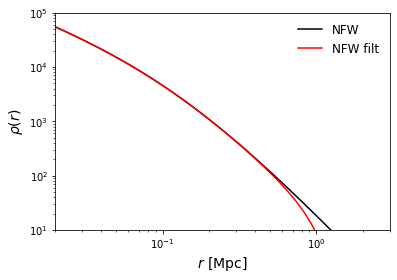

In [25]:
# Make a plot
plt.plot(r_arr_nfw,nfw_arr, 'k', label=r'NFW')
plt.plot(r_arr_nfw,nfw_arr_filt, 'r', label=r'NFW filt')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$ [Mpc]', fontsize=14)
plt.ylabel(r'$\rho(r)$', fontsize=14)
plt.xlim(2e-2,3e0)
plt.ylim(1e1,1e5)
plt.legend(loc='upper right', fontsize=12, frameon=False)

1e-05 999999.9999999979


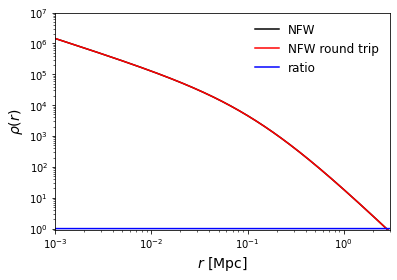

In [30]:
# get the power spectrum
#r,xi = HT.k_to_r(k,pk_nl0,1.5,-1.5,.5, (2.*np.pi)**(-1.5))
k_nfw,P_nfw = HT.r_to_k(r_arr_nfw,nfw_arr,-1.5,1.5,.5, (2.*np.pi)**(1.5))
r_check,xi_check = HT.k_to_r(k_nfw,P_nfw,1.5,-1.5,.5, (2.*np.pi)**(-1.5))

# Make a plot
plt.plot(r_arr_nfw,nfw_arr, 'k', label=r'NFW')
plt.plot(r_check,xi_check, 'r', label=r'NFW round trip')
plt.plot(r_check,nfw_arr/xi_check, 'b', label=r'ratio')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$ [Mpc]', fontsize=14)
plt.ylabel(r'$\rho(r)$', fontsize=14)
plt.xlim(1e-3,3e0)
plt.ylim(0.9e0,1e7)
plt.legend(loc='upper right', fontsize=12, frameon=False)

print(min(k_nfw),max(k_nfw))
np.savetxt('k_nfw',k_nfw)
np.savetxt('P_nfw',P_nfw)

In [31]:
#Compare with Danielle's NFW
nfw_danielle = np.loadtxt('danielle_nfw/Pkgm_1h_debug_Jonathan.txt')
k_dan=nfw_danielle[:,0]
P_dan=nfw_danielle[:,1]
r_dan,xi_dan=HT.k_to_r(k_dan,P_dan,1.5,-1.5,.5, (2.*np.pi)**(-1.5))

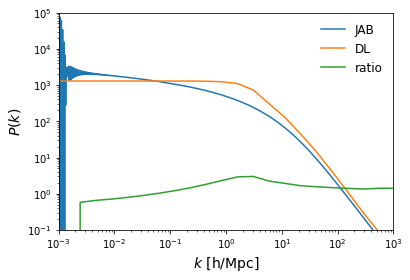

In [32]:
p_jab_interp=interp1d(k_nfw,P_nfw,fill_value='extrapolate')
xi_jab_interp=interp1d(r_arr_nfw,nfw_arr,fill_value='extrapolate')
plt.plot(k_nfw,P_nfw, label=r'JAB')
plt.plot(nfw_danielle[:,0],nfw_danielle[:,1], label=r'DL')
plt.plot(nfw_danielle[:,0],nfw_danielle[:,1]/p_jab_interp(nfw_danielle[:,0]),label=r'ratio')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-3,1e3)
plt.ylim(1e-1,1e5)
plt.xlabel('$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$', fontsize=14)
plt.legend(loc='upper right', fontsize=12, frameon=False)

(0.0, 1.5)

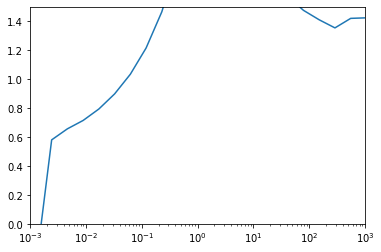

In [33]:
plt.plot(nfw_danielle[:,0],nfw_danielle[:,1]/p_jab_interp(nfw_danielle[:,0]),label=r'ratio')
plt.xscale('log')
plt.xlim(1e-3,1e3)
plt.ylim(0,1.5)

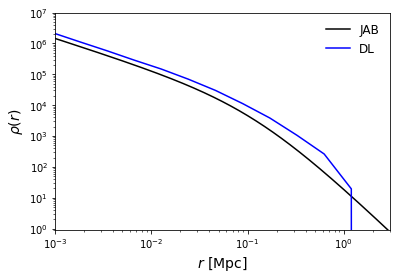

In [25]:
plt.plot(r_arr_nfw,nfw_arr, 'k', label=r'JAB')
plt.plot(r_dan,xi_dan, 'b', label=r'DL')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$ [Mpc]', fontsize=14)
plt.ylabel(r'$\rho(r)$', fontsize=14)
plt.xlim(1e-3,3e0)
plt.ylim(0.9e0,1e7)
plt.legend(loc='upper right', fontsize=12, frameon=False)

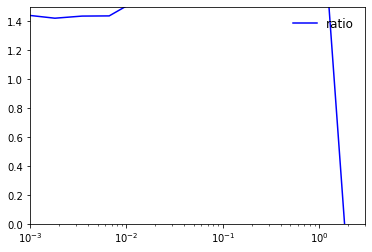

In [26]:
plt.plot(r_dan,xi_dan/xi_jab_interp(r_dan), 'b', label=r'ratio')
plt.xscale('log')
plt.xlim(1e-3,3e0)
plt.ylim(0,1.5)
plt.legend(loc='upper right', fontsize=12, frameon=False)

In [36]:
#1 halo contribution:
k_sm=10000.
P_IA_nfw = c_1_zz*P_nfw*np.exp(-1.*(k_nfw/k_sm)**2)
r_arr_nfw,wgplus_nfw_arr=HT.k_to_r(k_nfw,P_IA_nfw,1.,-1.,2., -1./(2*np.pi))

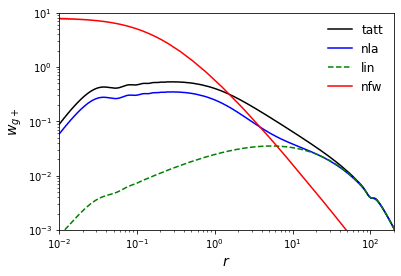

In [37]:
# Make a plot
plt.plot(r,abs(wgplus_tatt), 'k', label=r'tatt')
plt.plot(r,abs(wgplus_nla), 'b', label=r'nla')
plt.plot(r,abs(wgplus_lin), 'g--', label=r'lin')
plt.plot(r_arr_nfw,abs(wgplus_nfw_arr), 'r', label=r'nfw')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$', fontsize=14)
plt.ylabel(r'$w_{g+}$', fontsize=14)
plt.xlim(1e-2,2e2)
plt.ylim(1e-3,1e1)
plt.legend(loc='upper right', fontsize=12, frameon=False)

In [29]:
#interpolate the nfw contribution to the same r values.
wgplus_nfw_interp=interp1d(r_arr_nfw,wgplus_nfw_arr)
wgplus_nfw=wgplus_nfw_interp(r)
wgplus_nfw_interp(0.01)

array(7.79619225)

In [30]:
# So far, we have done the calculation for w_g+, although not all of the clustering terms are included.
# This is especially relevant for the NFW contribution, where clustering is significant.
# For <gamma_IA>, we can neglect the clustering issue.

# For this statisic, we divide by the projection length. 1/(2*Pi_max)
Pi_max=100 #in Mpc/h
Pi_max_arr = np.array([2, 2, 2, 2, 2.0556567522362013, 4.064039793469566, 8.02506523161952, 15.843748963711729, 31.262828303396116, 61.64985819213149])

In [31]:
#adj=7.5
adj=1.0
gamma_avg_lin=wgplus_lin/(2.*Pi_max)*adj
gamma_avg_nfw=wgplus_nfw/(2.*Pi_max)*adj
gamma_avg_tatt=wgplus_tatt/(2.*Pi_max)*adj
gamma_avg_nla=wgplus_nla/(2.*Pi_max)*adj

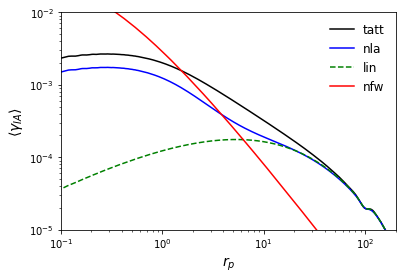

In [32]:
# Make a plot
plt.plot(r,abs(gamma_avg_tatt), 'k', label=r'tatt')
plt.plot(r,abs(gamma_avg_nla), 'b', label=r'nla')
plt.plot(r,abs(gamma_avg_lin), 'g--', label=r'lin')
plt.plot(r,abs(gamma_avg_nfw), 'r', label=r'nfw')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r_p$', fontsize=14)
plt.ylabel(r'$\langle \gamma_{IA} \rangle$', fontsize=14)
plt.xlim(1e-1,2e2)
plt.ylim(1e-5,1e-2)
plt.legend(loc='upper right', fontsize=12, frameon=False)

In [33]:
# Convert from r_p to theta for the redshift of the lenses: 0.3-0.45. Mean redshift used above is zz.
codist = h*ccl.background.comoving_radial_distance(cosmo,1./(1+zz))
conversion = codist/180*np.pi/60
theta1=r/codist*180/np.pi*60
theta=r/conversion

In [34]:
#read in the data
gammaIA1=np.loadtxt('lrGammaIAfinalw1') #This is old
cov1=np.loadtxt('lrCovMatw1')
err=np.diag(cov1)**0.5

lowzgp = np.loadtxt('lowz/lowz_full.dat')
cov_lowzgp = np.loadtxt('lowz/lowz_wgp_cov.dat')
err_lowzgp = np.diag(cov_lowzgp)**0.5

lowz = np.loadtxt('lowz/lowz_gamma.dat')

In [35]:
#read in new data gammaIA data
cov=np.load('10KsourceBins_1KlensBins/CovMat.npy')
data=np.loadtxt('10KsourceBins_1KlensBins/GammaIA')
theta_arr = np.loadtxt('10KsourceBins_1KlensBins/theta')
err_vals=np.diag(cov)**0.5

#read in gamma_t_lensing_correction
gamma_lensing = np.loadtxt('gamma_IA_est_DESY1_no_fidIA_measured-redshifts-wrong_variableF_Planck18pars_sigma=0.0001deltaz=0.03.txt')
#data format:
#0: theta (arcmin?)
#1: gamma_t from lensing

theta_vals=theta_arr[:,0] # this is the mean
print(theta_arr[:,0])
print(theta_arr[:,1])
print(gammaIA1[:,2])
print(Pi_max_arr)

[  0.30541   0.60341   1.1918    2.3571    4.6615    9.2158   18.198
  35.928    70.893   139.8    ]
[  0.28102317   0.55483822   1.09544512   2.1627926    4.27011061
   8.43069496  16.64514669  32.86335345  64.88377785 128.10331832]
[  0.30541   0.60341   1.1918    2.3571    4.6615    9.2158   18.198
  35.928    70.893   139.8    ]
[ 2.          2.          2.          2.          2.05565675  4.06403979
  8.02506523 15.84374896 31.2628283  61.64985819]


In [36]:
print(gamma_lensing)
print(theta_vals)

[[3.05410000e-01 5.29687012e-04]
 [6.03410000e-01 6.92081819e-04]
 [1.19180000e+00 9.29089237e-04]
 [2.35710000e+00 1.31570599e-03]
 [4.66150000e+00 2.07360205e-03]
 [9.21580000e+00 2.27588244e-03]
 [1.81980000e+01 1.17099099e-03]
 [3.59280000e+01 4.88779150e-04]
 [7.08930000e+01 1.82119199e-04]
 [1.39800000e+02 5.43564770e-05]]
[  0.30541   0.60341   1.1918    2.3571    4.6615    9.2158   18.198
  35.928    70.893   139.8    ]


In [37]:
# do the chi2 calculation
#wgplus_nfw/(2.*Pi_max)
theory = interp1d(r,gamma_avg_nfw)
theory_gplus = interp1d(r,wgplus_nfw)
theory1=theory_gplus(theta_vals*conversion)/(2.*Pi_max_arr)
theory2=theory(theta_vals*conversion) # this verson only has a single Pi_max value.
diff = data-theory1
cov_inv = np.linalg.inv(cov)
chi2=np.dot(diff,np.dot(cov_inv,diff))
print(chi2)
print(theory2/theory1)
print(Pi_max_arr)
print(conversion*theta_vals/h)

1157587.3981534273
[0.02       0.02       0.02       0.02       0.02055657 0.0406404
 0.08025065 0.15843749 0.31262828 0.61649858]
[ 2.          2.          2.          2.          2.05565675  4.06403979
  8.02506523 15.84374896 31.2628283  61.64985819]
[ 0.13722808  0.27112668  0.53550451  1.05910192  2.09452446  4.14088137
  8.17680062 16.14331755 31.85393596 62.81551419]


In [38]:
#test matrix mult
a=[1,2]
b=[4,5]
c=[[2,4],
  [3, 6]]
np.dot(a,b)
print(c)
np.dot(a,c)

[[2, 4], [3, 6]]


array([ 8, 16])

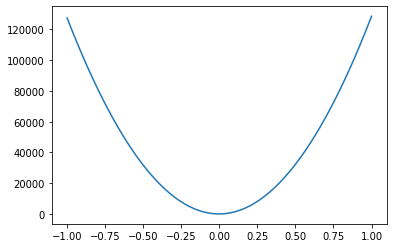

In [39]:
res=100
amp=np.linspace(-1,1,res)
chi2_arr=np.zeros_like(amp)
for i in range(res):
    ai=amp[i]
    theoryi=ai*theory1
    diff = data-theoryi
    chi2=np.dot(diff,np.dot(cov_inv,diff))
    #print(i)
    #print(ai)
    #print(chi2)
    chi2_arr[i]=chi2
dof = len(theta_vals)-1
plt.plot(amp,chi2_arr/dof)

[-4.56157797e-03  4.51804264e-04  1.56239517e-04  2.37917536e-03
  3.38634446e-03  2.05644200e-03  1.19820253e-03  4.94697841e-05
  7.97305965e-05  2.49786841e-05]


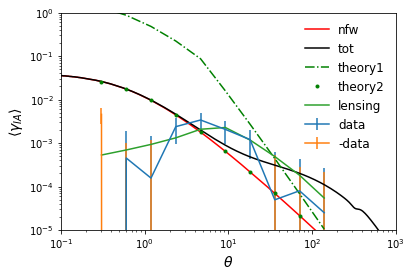

In [40]:
# Make a plot
#plt.plot(r,abs(gamma_avg_tatt), 'k', label=r'tatt')
#plt.plot(theta,gamma_avg_nla, 'b', label=r'nla')
#plt.plot(theta,abs(gamma_avg_lin), 'g--', label=r'lin')
plt.plot(theta,abs(gamma_avg_nfw), 'r', label=r'nfw')
plt.plot(theta,abs(gamma_avg_nfw+1.5*gamma_avg_lin), 'k', label=r'tot')
plt.errorbar(theta_vals,data, yerr=err_vals, label=r'data')
plt.errorbar(theta_vals,-1*data, yerr=err_vals, label=r'-data')
plt.plot(theta_vals,theory1, 'g-.',label=r'theory1')
plt.plot(theta_vals,theory2, 'g.',label=r'theory2')
plt.plot(gamma_lensing[:,0],gamma_lensing[:,1],label='lensing')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel(r'$\langle \gamma_{IA} \rangle$', fontsize=14)
plt.xlim(1e-1,1e3)
plt.ylim(1e-5,1e0)
plt.legend(loc='upper right', fontsize=12, frameon=False)
print(data)
outarr = np.ones

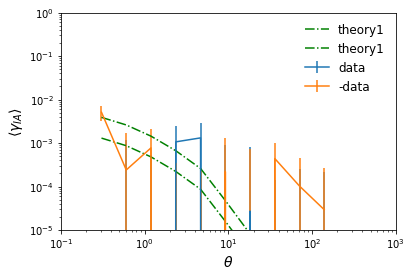

In [41]:
# Make a plot
#plt.plot(r,abs(gamma_avg_tatt), 'k', label=r'tatt')
#plt.plot(theta,gamma_avg_nla, 'b', label=r'nla')
#plt.plot(theta,abs(gamma_avg_lin), 'g--', label=r'lin')
#plt.plot(theta,abs(gamma_avg_nfw), 'r', label=r'nfw')
#plt.plot(theta,abs(gamma_avg_nfw+1.5*gamma_avg_lin), 'k', label=r'tot')
plt.errorbar(theta_vals,(data-gamma_lensing[:,1]), yerr=err_vals, label=r'data')
plt.errorbar(theta_vals,-1*(data-gamma_lensing[:,1]), yerr=err_vals, label=r'-data')
plt.plot(theta_vals,0.001*theory1, 'g-.',label=r'theory1')
plt.plot(theta_vals,0.003*theory1, 'g-.',label=r'theory1')
#plt.plot(theta_vals,theory2, 'g.',label=r'theory2')
#plt.plot(gamma_lensing[:,0],gamma_lensing[:,1],label='lensing')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel(r'$\langle \gamma_{IA} \rangle$', fontsize=14)
plt.xlim(1e-1,1e3)
plt.ylim(1e-5,1e0)
plt.legend(loc='upper right', fontsize=12, frameon=False)

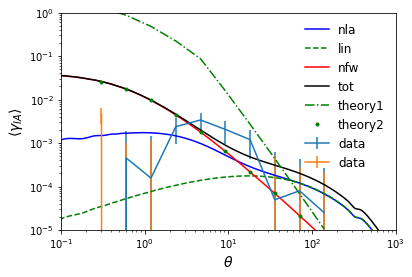

In [42]:
# Make a plot
#plt.plot(r,abs(gamma_avg_tatt), 'k', label=r'tatt')
plt.plot(theta,gamma_avg_nla, 'b', label=r'nla')
plt.plot(theta,abs(gamma_avg_lin), 'g--', label=r'lin')
plt.plot(theta,abs(gamma_avg_nfw), 'r', label=r'nfw')
plt.plot(theta,abs(gamma_avg_nfw+1.5*gamma_avg_lin), 'k', label=r'tot')
plt.errorbar(theta_vals,data, yerr=err_vals, label=r'data')
plt.errorbar(theta_vals,-1*data, yerr=err_vals, label=r'data')
plt.plot(theta_vals,theory1, 'g-.',label=r'theory1')
plt.plot(theta_vals,theory2, 'g.',label=r'theory2')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel(r'$\langle \gamma_{IA} \rangle$', fontsize=14)
plt.xlim(1e-1,1e3)
plt.ylim(1e-5,1e0)
plt.legend(loc='upper right', fontsize=12, frameon=False)

In [43]:
# output to file
out=np.zeros((len(theta_vals),3))
out[:,0]=theta_vals
out[:,1]=theory1
out[:,2]=theory2

np.savetxt('model_out_nfw.txt',out)

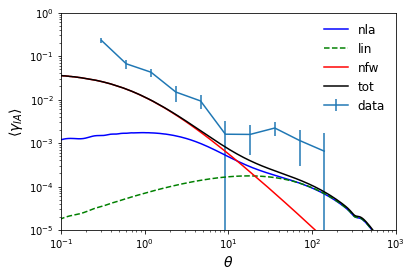

In [44]:
# Make a plot
#plt.plot(r,abs(gamma_avg_tatt), 'k', label=r'tatt')
plt.plot(theta,gamma_avg_nla, 'b', label=r'nla')
plt.plot(theta,abs(gamma_avg_lin), 'g--', label=r'lin')
plt.plot(theta,abs(gamma_avg_nfw), 'r', label=r'nfw')
plt.plot(theta,abs(gamma_avg_nfw+gamma_avg_lin), 'k', label=r'tot')
plt.errorbar(gammaIA1[:,2],gammaIA1[:,1], yerr=err, label=r'data')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel(r'$\langle \gamma_{IA} \rangle$', fontsize=14)
plt.xlim(1e-1,1e3)
plt.ylim(1e-5,1e0)
plt.legend(loc='upper right', fontsize=12, frameon=False)

[ 0.120627  0.17039   0.240682  0.339973  0.480224  0.678335  0.958173
  1.35346   1.91181   2.7005    3.81456   5.3882    7.61104  10.7509
 15.186    21.4508   30.3001   42.8      60.4566   85.3972  ]
[ 0.678335  0.958173  1.35346   1.91181   2.7005    3.81456   5.3882
  7.61104  10.7509   15.186    21.4508   30.3001   42.8      60.4566
 85.3972  ]
[0.02155615 0.01395812 0.00604912 0.00362404 0.00619194 0.00336164
 0.00271873 0.00280313 0.00156786 0.00155345 0.00122871 0.00087755
 0.0009378  0.00052283 0.00047963]


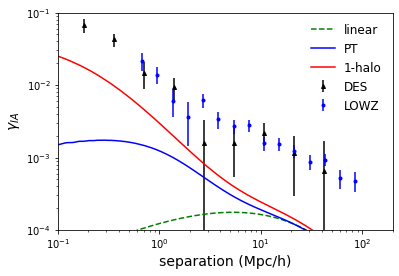

In [45]:
# Make a plot
#plt.plot(r,abs(gamma_avg_tatt), 'k', label=r'tatt')
plt.plot(r,abs(gamma_avg_lin), 'g--', label=r'linear')
plt.plot(r,gamma_avg_nla, 'b', label=r'PT')
#plt.plot(r,abs(gamma_avg_nfw), 'r', label=r'nfw')
plt.plot(r,abs(gamma_avg_nfw+gamma_avg_lin), 'r', label=r'1-halo')
plt.errorbar(gammaIA1[:,2]*conversion,gammaIA1[:,1], yerr=err, fmt='^k', markersize=4, label=r'DES')
fact=1e-2*1.1
ind=np.where(lowzgp[:,0]>0.5)[0]
plt.errorbar(lowzgp[ind,0],fact*lowzgp[ind,2], yerr=fact*err_lowzgp[ind], fmt='.b', label=r'LOWZ')
print(lowzgp[:,0])
print(lowzgp[ind,0])
print(fact*lowzgp[ind,2])
#ind=np.where(lowz[:,0]>0.5)[0]
#plt.errorbar(lowz[ind,0],lowz[ind,1], yerr=lowz[ind,2], fmt='ob', label=r'LOWZ')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'separation (Mpc/h)', fontsize=14)
plt.ylabel(r'$\gamma_{IA}$', fontsize=14)
plt.xlim(1e-1,2e2)
plt.ylim(1e-4,1e-1)
plt.legend(loc='upper right', fontsize=12, frameon=False)
plt.savefig('foo.pdf')
#pdf = PdfPages('foo.pdf')
#pdf.savefig()

In [46]:
# output to file
out=np.zeros((len(theta),5))
out[:,0]=theta
out[:,1]=gamma_avg_lin
out[:,2]=gamma_avg_nfw
out[:,3]=gamma_avg_lin+gamma_avg_nfw
out[:,4]=gamma_avg_nla

np.savetxt('IA_model_out.txt',out)

In [47]:
# modeling power law etc
from scipy.special import hyp2f1

In [48]:
def powproj(rp,A,alp,pim):
    "returns a (normalized) projected power law from +-Pi_max = pim"
    return A*rp**alp*hyp2f1(1/2,-alp/2,3/2,-(pim/rp)**2)
def powprojcos(rp,A,alp,pim):
    "returns a (normalized) projected power law from +-Pi_max = pim, with cos factor"
    return A*rp**alp*hyp2f1(1/2,-(alp-1)/2,3/2,-(pim/rp)**2)

In [49]:
rp = np.logspace(-1,2,20)
A=1
alp = -2
Pim=10

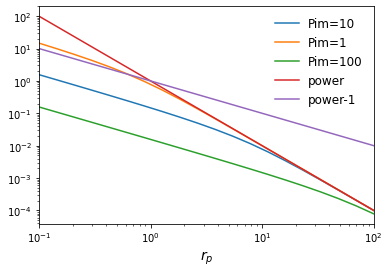

In [50]:
plt.plot(rp,powproj(rp,A,alp,Pim),label=r'Pim=10')
plt.plot(rp,powproj(rp,A,alp,0.1*Pim),label=r'Pim=1')
plt.plot(rp,powproj(rp,A,alp,10*Pim),label=r'Pim=100')
plt.plot(rp,A*rp**alp,label=r'power')
plt.plot(rp,A*rp**(alp+1),label=r'power-1')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r_p$', fontsize=14)
plt.xlim(1e-1,1e2)
#plt.ylim(1e-5,1e-2)
plt.legend(loc='upper right', fontsize=12, frameon=False)

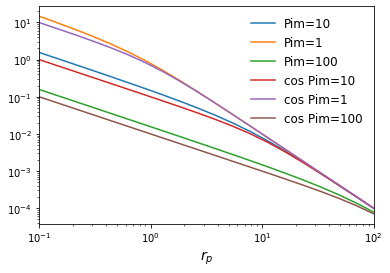

In [51]:
plt.plot(rp,powproj(rp,A,alp,Pim),label=r'Pim=10')
plt.plot(rp,powproj(rp,A,alp,0.1*Pim),label=r'Pim=1')
plt.plot(rp,powproj(rp,A,alp,10*Pim),label=r'Pim=100')
plt.plot(rp,powprojcos(rp,A,alp,Pim),label=r'cos Pim=10')
plt.plot(rp,powprojcos(rp,A,alp,0.1*Pim),label=r'cos Pim=1')
plt.plot(rp,powprojcos(rp,A,alp,10*Pim),label=r'cos Pim=100')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r_p$', fontsize=14)
plt.xlim(1e-1,1e2)
#plt.ylim(1e-5,1e-2)
plt.legend(loc='upper right', fontsize=12, frameon=False)

In [52]:
k=np.logspace(-1,2,100)
k1h=4.
k2h=6.
filt1=1.-np.exp(-1*(k/k1h)**2)
filt2=np.exp(-1*(k/k2h)**2)

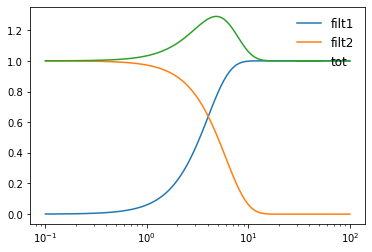

In [53]:
plt.plot(k,filt1,label=r'filt1')
plt.plot(k,filt2,label=r'filt2')
plt.plot(k,filt1+filt2,label=r'tot')
plt.xscale('log')
plt.legend(loc='upper right', fontsize=12, frameon=False)

In [54]:
#read in the final data
gammaIA=np.loadtxt('final/GammaIAfinal')
cov=np.loadtxt('final/CovMat')
err=np.loadtxt('final/ErrorBar')

In [55]:
print(gammaIA)

[-3.45063583e-03  2.58703120e-04  5.21180216e-05  9.54501406e-04
  9.32412289e-04  4.65897752e-04  2.38521357e-04  1.84421190e-05
  2.81589376e-05  6.90251263e-06]


In [56]:
print(gammaIA1[:,2])

[  0.30541   0.60341   1.1918    2.3571    4.6615    9.2158   18.198
  35.928    70.893   139.8    ]


In [57]:
print(conversion)

0.30248500826844954


In [58]:
print(gammaIA/err)

[-2.4141031   0.26731763  0.07126192  1.63031638  2.34178882  2.08106876
  1.83749469  0.14677559  0.24119928  0.04761208]


In [59]:
print(cov)

[[ 2.04308591e-06 -1.48453131e-07  2.46087442e-08  9.29459762e-08
   6.51799721e-08 -6.76095733e-10  5.13869454e-08  3.35040028e-08
   1.87773468e-08 -9.00794761e-09]
 [-1.48453131e-07  9.36587003e-07  7.51950027e-08  1.78823974e-07
   4.46775688e-08  4.62280837e-08  3.13844877e-09 -6.22120404e-09
   1.38546842e-08  3.31284471e-08]
 [ 2.46087442e-08  7.51950027e-08  5.34885521e-07  1.08746635e-07
  -5.82671377e-08  1.49650333e-08  1.55475664e-08  1.80565205e-08
   5.07875246e-09  2.01472150e-08]
 [ 9.29459762e-08  1.78823974e-07  1.08746635e-07  3.42775176e-07
  -1.34049443e-08  2.26956915e-08  1.07656990e-08 -9.33414096e-09
   1.00294166e-08  7.12323741e-09]
 [ 6.51799721e-08  4.46775688e-08 -5.82671377e-08 -1.34049443e-08
   1.58533308e-07  1.81463107e-08 -8.59052480e-09 -1.19676628e-08
  -1.20104571e-08 -9.38572165e-09]
 [-6.76095733e-10  4.62280837e-08  1.49650333e-08  2.26956915e-08
   1.81463107e-08  5.01196893e-08  4.84732801e-09  4.65323411e-09
  -1.84726906e-10 -9.87392753e-10

In [60]:
print(gammaIA1[:,1])

[0.2283099  0.06636676 0.04253619 0.0148861  0.00928301 0.0015954
 0.00157716 0.00221387 0.00114561 0.00065101]


In [61]:
conversion*(gammaIA1[:,2])

array([ 0.09238195,  0.18252248,  0.36050163,  0.71298741,  1.41003387,
        2.78764134,  5.50462218, 10.86768138, 21.44406969, 42.28740416])

In [62]:
# Redmapper data.
# data for fig 10
xi_rm = np.array([0.0508, 0.0363, 0.0188, 0.0074, 0.0078,  -0.0014,  -0.0015,  -0.0023, - 0.001, -0.0018])
rnom_rm = np.array([0.01353062, 0.02110385, 0.03360098, 0.05466126, 0.08808967, 0.14207503,
 0.22857292, 0.36644751, 0.58731146, 0.90538048])
cov_rm = np.array([[ 2.1790e-05, -6.2833e-08,  2.9239e-07,  3.4022e-07, -1.1349e-07,
         1.4725e-07, -1.0124e-08,  7.8146e-08,  5.0958e-08,  5.8533e-08],
       [-6.2833e-08,  1.0375e-05,  1.6670e-07,  7.6514e-08,  8.0567e-08,
         1.6947e-08,  4.7715e-08,  5.9347e-08,  1.5666e-08, -7.9602e-08],
       [ 2.9239e-07,  1.6670e-07,  7.0001e-06,  5.1955e-08,  1.1944e-07,
        -8.5474e-08,  6.3328e-08,  5.1129e-08, -6.9425e-08,  6.8686e-09],
       [ 3.4022e-07,  7.6514e-08,  5.1955e-08,  5.1607e-06, -1.8085e-08,
        -3.6357e-08,  5.8089e-08,  3.4636e-08,  1.5998e-09,  5.4483e-09],
       [-1.1349e-07,  8.0567e-08,  1.1944e-07, -1.8085e-08,  3.6807e-06,
        -2.1827e-08, -1.9179e-08,  2.3699e-08, -4.4246e-08, -3.2119e-08],
       [ 1.4725e-07,  1.6947e-08, -8.5474e-08, -3.6357e-08, -2.1827e-08,
         2.4065e-06, -2.2190e-08,  1.9548e-10, -6.8319e-08,  4.8395e-08],
       [-1.0124e-08,  4.7715e-08,  6.3328e-08,  5.8089e-08, -1.9179e-08,
        -2.2190e-08,  1.6472e-06,  2.1654e-08,  2.7868e-08, -3.4693e-08],
       [ 7.8146e-08,  5.9347e-08,  5.1129e-08,  3.4636e-08,  2.3699e-08,
         1.9548e-10,  2.1654e-08,  1.2086e-06,  2.1886e-09, -1.5303e-08],
       [ 5.0958e-08,  1.5666e-08, -6.9425e-08,  1.5998e-09, -4.4246e-08,
        -6.8319e-08,  2.7868e-08,  2.1886e-09,  9.6792e-07, -5.1755e-10],
       [ 5.8533e-08, -7.9602e-08,  6.8686e-09,  5.4483e-09, -3.2119e-08,
         4.8395e-08, -3.4693e-08, -1.5303e-08, -5.1755e-10,  1.2233e-06]])
err_rm = np.diag(cov_rm)**0.5

In [63]:
###### gamma_r on the absolute scale (Mpc/h)######
r_abs = np.array([0.0132, 0.0212, 0.0338, 0.055 , 0.0887, 
			  0.1439, 0.2315, 0.3727,0.5957, 0.8483])
gamma_abs = np.array([ 0.0422,  0.0284,  0.0118,  0.0068,  
			   0.0031, -0.001 , -0.0034,-0.0024, -0.0005, -0.0006])
std_gamma = np.array([0.0037, 0.0029, 0.0025, 0.0021, 0.0017,
					  0.0014, 0.0012, 0.001 ,0.001 , 0.0018])



###### separation normalized by R_lambda. ######
r_norm = np.array([0.0135, 0.0211, 0.0336, 0.0547, 0.0881,
			  0.1421, 0.2286, 0.3664, 0.5873, 0.9053])
gamma_norm = np.array([ 0.0508,  0.0363,  0.0188,  0.0074, 0.0078, 
				  -0.0014, -0.0015, -0.0023, -0.001 , -0.0018])
std_gamma_norm = np.array([0.0047, 0.0032, 0.0026, 0.0023, 0.0019, 
					  0.0016, 0.0013, 0.0011, 0.001 , 0.0011])

###### correction factor #### (interpolate?)
mean_logr=np.array([-4.33235786, -3.84809175, -3.37697537, -2.89016662,-2.41615232,
                    -1.93716225, -1.4576063 , -0.97848255, -0.4996488 , -0.01996365])

mean_r = np.exp(mean_logr)
print(mean_r)

gamma_r_corr=np.array([ 3.62073591e-02,  7.85501162e-03, -6.27521722e-04, -3.95114353e-03, -5.60755606e-03, -1.80915016e-03,
                       5.25956938e-04, 6.30038505e-04, -2.63320259e-04,  8.09280450e-05])

jk_error = np.array([0.01498038, 0.00939491, 0.00683407, 0.00437869, 0.00290118,
       0.00180911, 0.00116338, 0.00073342, 0.00047089, 0.00028807])

gamma_r_corr_interp_func = interp1d(mean_logr,gamma_r_corr)
gamma_r_corr_interp = gamma_r_corr_interp_func(np.log(r_abs))

jk_error_interp_func = interp1d(mean_logr,jk_error)
jk_error_interp = jk_error_interp_func(np.log(r_abs))

gamma_abs_total = gamma_abs - gamma_r_corr_interp
std_total = (std_gamma**2 + jk_error_interp**2)**0.5

[0.01313654 0.02132038 0.03415059 0.05556695 0.08926442 0.14411232
 0.23279284 0.37588105 0.60674371 0.9802343 ]


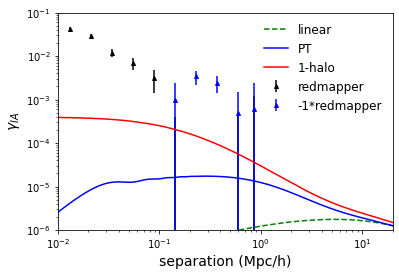

In [64]:
# Make a plot
fact = 0.010
#plt.plot(r,abs(gamma_avg_tatt), 'k', label=r'tatt')
plt.plot(r,fact*gamma_avg_lin, 'g--', label=r'linear')
plt.plot(r,fact*gamma_avg_nla, 'b', label=r'PT')
#plt.plot(r,abs(gamma_avg_nfw), 'r', label=r'nfw')
plt.plot(r,fact*abs(gamma_avg_nfw+gamma_avg_lin), 'r', label=r'1-halo')
plt.errorbar(r_abs,gamma_abs, yerr=std_gamma, fmt='^k', markersize=4, label=r'redmapper')
plt.errorbar(r_abs,-1.*gamma_abs, yerr=std_gamma, fmt='^b', markersize=4, label=r'-1*redmapper')
#fact=1e-2*1.1
#ind=np.where(lowzgp[:,0]>0.5)[0]
#plt.errorbar(lowzgp[ind,0],fact*lowzgp[ind,2], yerr=fact*err_lowzgp[ind], fmt='.b', label=r'LOWZ')

#ind=np.where(lowz[:,0]>0.5)[0]
#plt.errorbar(lowz[ind,0],lowz[ind,1], yerr=lowz[ind,2], fmt='ob', label=r'LOWZ')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'separation (Mpc/h)', fontsize=14)
plt.ylabel(r'$\gamma_{IA}$', fontsize=14)
plt.xlim(1e-2,2e1)
plt.ylim(1e-6,1e-1)
plt.legend(loc='upper right', fontsize=12, frameon=False)
plt.savefig('foo.pdf')
#pdf = PdfPages('foo.pdf')
#pdf.savefig()

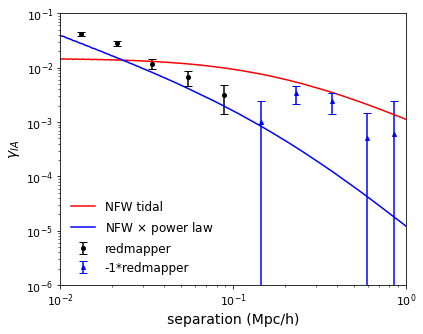

In [65]:
# Make a plot

plt.rcParams.update({'font.size': 11}) # before plotting coode
plt.figure(figsize=(6.2,5))

plt.tight_layout()
#plt.subplots_adjust(hspace=0,wspace=0) # if doing multiple panels/subplots

r0=2.3e-2
correction = (r/r0)**(-1.2)


fact = 0.050*7.5
#plt.plot(r,abs(gamma_avg_tatt), 'k', label=r'tatt')
#plt.plot(r,fact*gamma_avg_lin, 'g--', label=r'linear')
#plt.plot(r,fact*gamma_avg_nla, 'b', label=r'PT')
#plt.plot(r,abs(gamma_avg_nfw), 'r', label=r'nfw')
plt.plot(r,fact*abs(gamma_avg_nfw+gamma_avg_lin), 'r', label=r'NFW tidal')
plt.plot(r,fact*abs(gamma_avg_nfw+gamma_avg_lin)*correction, 'b', label=r'NFW $\times$ power law')
#plt.errorbar(np.exp(meanlogr),xi,yerr=varxi,fmt='o', capsize=4)
plt.errorbar(r_abs[np.where(gamma_abs>0)],gamma_abs[np.where(gamma_abs>0)], yerr=std_gamma[np.where(gamma_abs>0)], fmt='ok', markersize=4, capsize=4,label=r'redmapper')
plt.errorbar(r_abs,-1.*gamma_abs, yerr=std_gamma, fmt='^b', markersize=4, capsize=4, label=r'-1*redmapper')

#plt.errorbar(r_abs[np.where(gamma_abs_total>0)],gamma_abs_total[np.where(gamma_abs_total>0)], yerr=std_total[np.where(gamma_abs_total>0)], fmt='og', markersize=4, capsize=4,label=r'redmapper corrected')
#plt.errorbar(r_abs[np.where(gamma_abs_total<0)],-1.*gamma_abs_total[np.where(gamma_abs_total<0)], yerr=std_total[np.where(gamma_abs_total<0)], fmt='^r', markersize=4, capsize=4,label=r'redmapper corrected')

#fact=1e-2*1.1
#ind=np.where(lowzgp[:,0]>0.5)[0]
#plt.errorbar(lowzgp[ind,0],fact*lowzgp[ind,2], yerr=fact*err_lowzgp[ind], fmt='.b', label=r'LOWZ')

#ind=np.where(lowz[:,0]>0.5)[0]
#plt.errorbar(lowz[ind,0],lowz[ind,1], yerr=lowz[ind,2], fmt='ob', label=r'LOWZ')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'separation (Mpc/h)', fontsize=14)
plt.ylabel(r'$\gamma_{IA}$', fontsize=14)
plt.xlim(1e-2,1e0)
plt.ylim(1e-6,1e-1)
plt.legend(loc='lower left', fontsize=12, frameon=False)
plt.savefig('model.pdf', bbox_inches='tight')
#pdf = PdfPages('foo.pdf')
#pdf.savefig()


#output a file:
out=np.zeros((len(r),3))
out[:,0]=r
out[:,1]=fact*abs(gamma_avg_nfw+gamma_avg_lin)
out[:,2]=fact*abs(gamma_avg_nfw+gamma_avg_lin)*correction
np.savetxt('model_RM.txt',out)

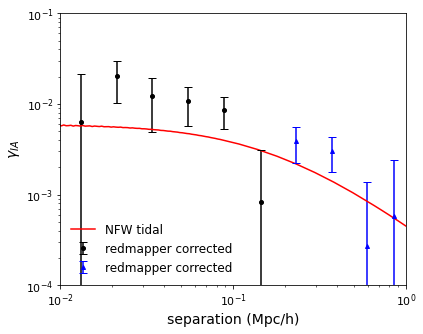

In [66]:
# Make a plot

plt.rcParams.update({'font.size': 11}) # before plotting coode
plt.figure(figsize=(6.2,5))

plt.tight_layout()
#plt.subplots_adjust(hspace=0,wspace=0) # if doing multiple panels/subplots

r0=2.3e-2
correction = (r/r0)**(-1.2)


fact = 0.02*7.5
#plt.plot(r,abs(gamma_avg_tatt), 'k', label=r'tatt')
#plt.plot(r,fact*gamma_avg_lin, 'g--', label=r'linear')
#plt.plot(r,fact*gamma_avg_nla, 'b', label=r'PT')
#plt.plot(r,abs(gamma_avg_nfw), 'r', label=r'nfw')
plt.plot(r,fact*abs(gamma_avg_nfw+gamma_avg_lin), 'r', label=r'NFW tidal')

#plt.plot(r,fact*abs(gamma_avg_nfw+gamma_avg_lin)*correction, 'b', label=r'NFW $\times$ power law')
#plt.errorbar(np.exp(meanlogr),xi,yerr=varxi,fmt='o', capsize=4)

#plt.errorbar(r_abs[np.where(gamma_abs>0)],gamma_abs[np.where(gamma_abs>0)], yerr=std_gamma[np.where(gamma_abs>0)], fmt='ok', markersize=4, capsize=4,label=r'redmapper')
#plt.errorbar(r_abs,-1.*gamma_abs, yerr=std_gamma, fmt='^b', markersize=4, capsize=4, label=r'-1*redmapper')

plt.errorbar(r_abs[np.where(gamma_abs_total>0)],gamma_abs_total[np.where(gamma_abs_total>0)], yerr=std_total[np.where(gamma_abs_total>0)], fmt='ok', markersize=4, capsize=4,label=r'redmapper corrected')
plt.errorbar(r_abs[np.where(gamma_abs_total<0)],-1.*gamma_abs_total[np.where(gamma_abs_total<0)], yerr=std_total[np.where(gamma_abs_total<0)], fmt='^b', markersize=4, capsize=4,label=r'redmapper corrected')

#fact=1e-2*1.1
#ind=np.where(lowzgp[:,0]>0.5)[0]
#plt.errorbar(lowzgp[ind,0],fact*lowzgp[ind,2], yerr=fact*err_lowzgp[ind], fmt='.b', label=r'LOWZ')

#ind=np.where(lowz[:,0]>0.5)[0]
#plt.errorbar(lowz[ind,0],lowz[ind,1], yerr=lowz[ind,2], fmt='ob', label=r'LOWZ')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'separation (Mpc/h)', fontsize=14)
plt.ylabel(r'$\gamma_{IA}$', fontsize=14)
plt.xlim(1e-2,1e0)
plt.ylim(1e-4,1e-1)
plt.legend(loc='lower left', fontsize=12, frameon=False)
plt.savefig('model2.pdf', bbox_inches='tight')
#pdf = PdfPages('foo.pdf')
#pdf.savefig()


#output a file:
out=np.zeros((len(r),3))
out[:,0]=r
out[:,1]=fact*abs(gamma_avg_nfw+gamma_avg_lin)
out[:,2]=fact*abs(gamma_avg_nfw+gamma_avg_lin)*correction
np.savetxt('model_RM2.txt',out)

In [67]:
# tesla's paper on vel disp of redmapper
# check for numerical convergence (e.g. just on NLA, and then for NFW)
# mass and concentration

In [68]:
print(gamma_avg_lin/gamma_avg_nla)

[0.02790095 0.02608027 0.02411395 0.02283469 0.02133079 0.0204359
 0.0192891  0.0186659  0.0177933  0.01736265 0.01669984 0.01640486
 0.01590239 0.01570336 0.01532349 0.01519234 0.01490624 0.0148231
 0.0146088  0.01455976 0.01440075 0.014376   0.01425974 0.0142526
 0.01416981 0.01417581 0.01411966 0.01413589 0.01410135 0.014126
 0.01410945 0.01414152 0.01414046 0.01417962 0.01419252 0.014239
 0.01426504 0.01431947 0.01435848 0.01442188 0.01447429 0.01454811
 0.0146149  0.01470097 0.01478364 0.0148842  0.01498481 0.01510252
 0.0152236  0.01536148 0.01550593 0.01566722 0.01583812 0.01602592
 0.01622595 0.01644255 0.01667313 0.01691887 0.01717873 0.01745032
 0.01773362 0.01802231 0.01831701 0.01860754 0.01889542 0.0191677
 0.01942809 0.0196632  0.01988086 0.02007004 0.02024416 0.02039611
 0.02054443 0.02068518 0.02083969 0.02100465 0.02120101 0.02142285
 0.02168758 0.02198309 0.02232019 0.02267726 0.02305687 0.02342829
 0.02379055 0.02411347 0.02440631 0.02465488 0.02488931 0.02511392
 0.

Comparison with galsim shear profile from galsim (produced by Jacqueline)

"here are the tangential shear profiles. The galaxies are at 1.284, about the mean redshift of COSMOS2015 IIRC. Omega_m=0.3, Omega_lambda=0.7, h=0.7 cosmology. Those are for 1E14 and 1E14/h solar mass clusters."

1) radius is in pixels (a convenience thing for me). You can turn it onto arcseconds by multiplying those numbers by (0.144/60). Should have done that before, sorry.
2) g is shear without the factor of 1/(1 - kappa)
3) x is some dimensionless unit of projected distance equivalent to distance on image in radians divided by NFW scale radius. It's used in the calculations of shear, and defined in here.  https://ui.adsabs.harvard.edu/abs/2000ApJ...534...34W/abstract

In [69]:
d = np.loadtxt('mccleary_nfw_test/nfw_plotted_jb.txt')

In [70]:
print(d[:,1])

[0.11330316 0.10236291 0.09340071 0.08585712 0.07938631 0.07375736
 0.06880712 0.06441538 0.06049066 0.05696154 0.05377114 0.05087338
 0.0482304  0.04581076 0.04358807 0.04153995 0.03964734 0.03789385
 0.03626531 0.03474939 0.03333533 0.03201369 0.03077612 0.02961527
 0.02852459 0.02749823 0.02653098 0.02561816 0.02475555 0.02393937
 0.02316618 0.02243288 0.02173663 0.02107487 0.02044526 0.01984565
 0.01927408 0.01872875 0.01820801 0.01771035 0.01723435 0.01677873
 0.01634229 0.01592392 0.01552261 0.01513738 0.01476737 0.01441175
 0.01406975 0.01374066 0.0134238  0.01311857 0.01282436 0.01254064
 0.0122669  0.01200265 0.01174744 0.01150086 0.01126249 0.01103197
 0.01080894 0.01059307 0.01038405 0.01018157 0.00998535 0.00979514
 0.00961068 0.00943172 0.00925806 0.00908946 0.00892574 0.00876669
 0.00861213 0.0084619  0.00831582 0.00817374 0.0080355  0.00790097
 0.00777001 0.00764249 0.00751829 0.00739728 0.00727936 0.00716441
 0.00705234 0.00694305 0.00683644 0.00673242 0.0066309  0.0065

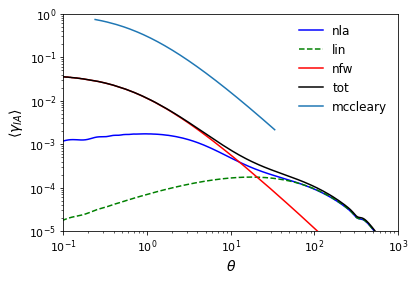

In [71]:
# Make a plot
#plt.plot(r,abs(gamma_avg_tatt), 'k', label=r'tatt')
plt.plot(theta,gamma_avg_nla, 'b', label=r'nla')
plt.plot(theta,abs(gamma_avg_lin), 'g--', label=r'lin')
plt.plot(theta,abs(gamma_avg_nfw), 'r', label=r'nfw')
plt.plot(theta,abs(gamma_avg_nfw+gamma_avg_lin), 'k', label=r'tot')
#plt.errorbar(gammaIA1[:,2],gammaIA1[:,1], yerr=err, label=r'data')
plt.plot(d[:,0],d[:,2],label=r'mccleary')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel(r'$\langle \gamma_{IA} \rangle$', fontsize=14)
plt.xlim(1e-1,1e3)
plt.ylim(1e-5,1e0)
plt.legend(loc='upper right', fontsize=12, frameon=False)

In [72]:
# need to compare at equivalent physical scale, since redshift of clusters is different.

In [73]:
d[:,0]

array([ 0.24 ,  0.288,  0.336,  0.384,  0.432,  0.48 ,  0.528,  0.576,
        0.624,  0.672,  0.72 ,  0.768,  0.816,  0.864,  0.912,  0.96 ,
        1.008,  1.056,  1.104,  1.152,  1.2  ,  1.248,  1.296,  1.344,
        1.392,  1.44 ,  1.488,  1.536,  1.584,  1.632,  1.68 ,  1.728,
        1.776,  1.824,  1.872,  1.92 ,  1.968,  2.016,  2.064,  2.112,
        2.16 ,  2.208,  2.256,  2.304,  2.352,  2.4  ,  2.448,  2.496,
        2.544,  2.592,  2.64 ,  2.688,  2.736,  2.784,  2.832,  2.88 ,
        2.928,  2.976,  3.024,  3.072,  3.12 ,  3.168,  3.216,  3.264,
        3.312,  3.36 ,  3.408,  3.456,  3.504,  3.552,  3.6  ,  3.648,
        3.696,  3.744,  3.792,  3.84 ,  3.888,  3.936,  3.984,  4.032,
        4.08 ,  4.128,  4.176,  4.224,  4.272,  4.32 ,  4.368,  4.416,
        4.464,  4.512,  4.56 ,  4.608,  4.656,  4.704,  4.752,  4.8  ,
        4.848,  4.896,  4.944,  4.992,  5.04 ,  5.088,  5.136,  5.184,
        5.232,  5.28 ,  5.328,  5.376,  5.424,  5.472,  5.52 ,  5.568,
      